# PHY407 Project

## Monte Carlo solutions to PDEs - random walks to solve Laplace's equations

#### This notebook aims to showcase how Monte Carlo method can be used to solve Laplace's equation. In particular, we will be exploring the distribution of temperature with a set boundary condition

#### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Setting global constants

In [155]:
# Constants
M = 200 # width of boundary (mm)
h = 80 # height of boundary (mm)
target = 1e-6   # Target accuracy

#### Defining helper functions to present the results graphically

In [156]:
def draw(data):
    fig = plt.figure()
    img = plt.imshow(data, extent=[0,20,0,8])
    cb = plt.colorbar(img,fraction=0.076, pad=0.04)
    cb.set_label('Temperature (C)')
    plt.title('Temperature distribution in a heat conductor')
    plt.xlabel('x coordinates (cm)')
    plt.ylabel('y coordinates (cm)')
#     plt.savefig("q1d_w={}.jpg".format(omega))
    plt.show()

In [207]:
def threeD(data):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 201)/10
    y = np.arange(0, 81)/10
    y = np.flip(y)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, data, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_xlabel("x coordinates (cm)")
    ax.set_ylabel("y coordinates (cm)")
    ax.set_zlabel("Temperature (C)")
    plt.show()

### Gauss-Seidel relaxation with replacement and overrelaxation method

In [171]:
# Create arrays to hold temperature values
phi0 = np.zeros([h+1,M+1],float)

# Setting initial boundary conditions
phi0[0,:] = 25

omega = 0.9 # relaxation coefficient
delta = 2 * target # initial accuracy

#### main body of the method: taking the average of the neighbours' value and repeat until desired accuracy is reached. Also record the time needed to find the solution of a specific point

In [173]:
start = time.time()
while delta>target:
    delta = 0.0
    for i in range(h):
        for j in range(M):
            if (i!=0 and i!=h and j!=0 and j!=M):
                oldvalue = phi0[i, j]
                phi0[i, j] = (1 + omega) * (phi0[i + 1, j] + phi0[i - 1, j] + phi0[i, j + 1] + phi0[i, j - 1]) / 4 \
                          - omega * phi0[i, j]

                delta = max(delta, np.abs(phi0[i, j] - oldvalue))
                
print("temperature at x=2.5cm y=1cm:", phi0[55][10],"C")
end = time.time()
print("time taken", end-start, "s")

temperature at x=2.5cm y=1cm: 1.6394307845711975 C
time taken 42.68349242210388 s


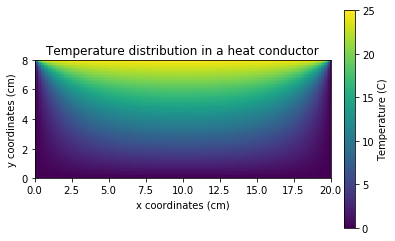

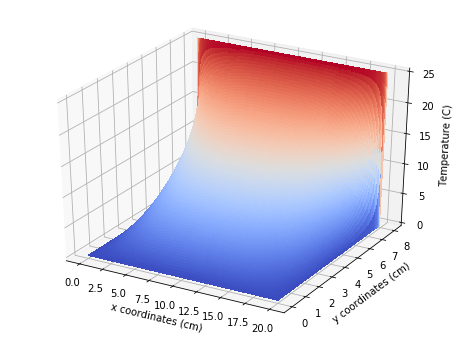

In [210]:
draw(phi0)
threeD(phi0)

### Monte Carlo method: take N random walks

#### defined the following 3 functions to perform N random walks starting from a given point and ending each walk when it reaches a boundary. Then record which boundary point the path reached. Finally, calculate the average frequency of each boundary point reached by the paths to get the approximation

In [38]:
def monteWalk(x, y):
    chance = np.random.uniform()
    if chance < 0.25:
        return x, y+1
    elif 0.25 <= chance < 0.5:
        return x, y-1
    elif 0.5 <= chance < 0.75:
        return x-1, y
    elif 0.75 <= chance < 1.0:
        return x+1, y
    else:
        raise ValueError("you rolled your dice too hard")

In [44]:
def walkToBoundary(shape, point):
    h, w = shape
    x, y = point
    while 0 <= x <= w - 1 and 0 <= y <= h - 1:
        x, y = monteWalk(x,y)
        if x < 0:
            return x+1, y
        elif x > w-1:
            return x-1, y
        elif y < 0:
            return x, y+1
        elif y > h -1:
            return x, y-1

In [82]:
def walkNtimes(data, point, N):
    results = np.zeros_like(data)
    for i in range(N):
        x, y = walkToBoundary(data.shape, point)
        results[y][x] += 1
    return np.sum(results/N * data)
    

#### Sanitiy check that Monte Carlo is not blind guessing

In [101]:
boundary = walkNtimes(phi, (55,0), 200)
print("temperature at boundary:", boundary, "C")

temperature at boundary: 25.0 C


#### check the time needed to approximate the same point

In [175]:
start = time.time()
test = walkNtimes(phi, (10,55), 300)
print("temperature at x=2.5cm y=1cm:", test, "C")
end = time.time()
print("time taken", end-start, "s")

temperature at x=2.5cm y=1cm: 1.8333333333333335 C
time taken 0.34310102462768555 s


#### use the Monte Carlo Method for the whole grid. Note: this will take a long time

In [98]:
# Create arrays to hold temperature values
phi = np.zeros([h+1,M+1],float)

# Setting initial boundary conditions
phi[0,:] = 25

omega = 0.9 # relaxation coefficient
delta = 2 * target # initial accuracy

#### Note: as discussed in the report, we only need to consider the non-boundary points

In [107]:
for i in range(1, phi.shape[0]-1):
    for j in range(1, phi.shape[1]-1):
        phi[i][j] = walkNtimes(phi, (j, i), 100)

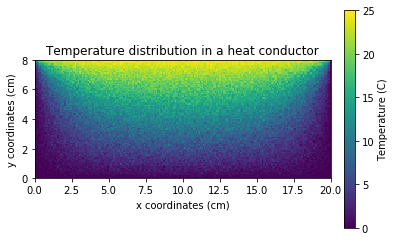

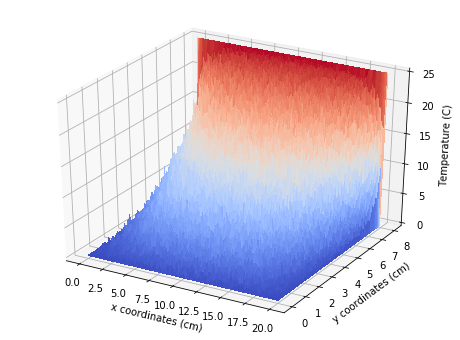

In [211]:
draw(phi)
threeD(phi)

#### Calculate the percentage error using the Gauss-Seidel method as reference

In [166]:
diff = np.sum(np.abs(phi - phi0))/np.sum(phi0)
print("percentage error compared to finite difference:", diff*100, "%")

mean percentage error compared to finite difference 7.755180008759742 %


## Unusual Laplace's equation

#### Checking that the probability derived also sums to one in Python

In [152]:
x = 2
print(1/(2*(1+np.sin(x))) + 1/(2*(1+np.sin(x))) + np.sin(x)/(2*(1+np.sin(x))) + np.sin(x)/(2*(1+np.sin(x))))

1.0


In [10]:
def monteWalkWithDiffProb(x, y):
    choices = [(x,y+1), (x,y-1), (x+1,y), (x+1,y)]
    probability = [1/(2*(1+np.sin(x))), 1/(2*(1+np.sin(x))), np.sin(x)/(2*(1+np.sin(x))), np.sin(x)/(2*(1+np.sin(x)))]
    print(np.sum(probability))
    print(probability)
    return choices[np.random.choice(4, p=probability)]

#### Testing that the code works.
Note: the value of x must be smaller than pi since we cannot have negative probabilities

In [15]:
monteWalkWithDiffProb(2,1)

1.0
[0.2618764331711687, 0.2618764331711687, 0.2381235668288313, 0.2381235668288313]


(3, 1)

#### Example implementation

In [16]:
def walkToBoundaryWithDiffProb(shape, point):
    h, w = shape
    x, y = point
    while 0 <= x <= w - 1 and 0 <= y <= h - 1:
        x, y = monteWalkWithDiffProb(x,y)
        if x < 0:
            return x+1, y
        elif x > w-1:
            return x-1, y
        elif y < 0:
            return x, y+1
        elif y > h -1:
            return x, y-1